In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/tmdb_5000_credits.csv', engine='python')


PREPROCESSING

In [2]:
movies = movies.merge(credits,on='title')
# movies.info()
movies = movies[ ['movie_id','title','overview','genres','keywords','cast','crew'] ]

In [3]:
movies.dropna(inplace=True)
# movies.isnull().sum()
movies.duplicated().sum()

# movies.info()

np.int64(0)

In [4]:
# print(type(movies.iloc[0]['genres']))
# print(movies.iloc[0]['genres'])

import ast
def convert(obj):
  L = []
  obj = ast.literal_eval(obj)
  for i in obj:
    L.append(i['name'])
  return L

movies['genres'] = movies['genres'].apply(convert)

In [5]:
movies['keywords'] = movies['keywords'].apply(convert)

In [6]:
movies['cast'].iloc[0]
def convertForcast(obj):
  L = []
  obj = ast.literal_eval(obj)
  for i in obj:
    if len(L)<=3:
      L.append(i['name'])
    else:
      break
  return L

movies['cast'] = movies['cast'].apply(convertForcast)


In [7]:
def fetch_director(obj):
  L = []
  obj = ast.literal_eval(obj)
  for i in obj:
    if i['job'] == 'Director':
      L.append(i['name'])
  return L

movies['crew'] = movies['crew'].apply(fetch_director)
movies['overview'] = movies['overview'].apply(lambda x:x.split())


In [8]:
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])

In [9]:
movies['tags'] =  movies['overview']+ movies['genres'] + movies['keywords']  + movies['cast'] + movies['crew']

new_df = movies[['movie_id','title','tags']]

new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))

/tmp/ipython-input-3499043931.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x))


In [10]:
new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())

/tmp/ipython-input-3214958533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())


In [11]:
new_df['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver stephenlang jamescameron'

DATA ANALYSIS

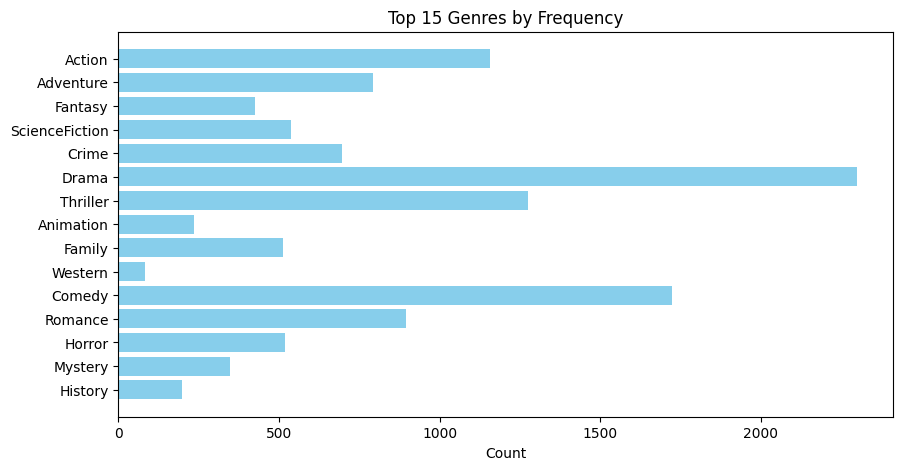

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

all_genres = [g for sublist in movies['genres'] for g in sublist]
genre_counts = Counter(all_genres)

plt.figure(figsize=(10,5))
plt.barh(list(genre_counts.keys())[:15], list(genre_counts.values())[:15], color='skyblue')
plt.title("Top 15 Genres by Frequency")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()



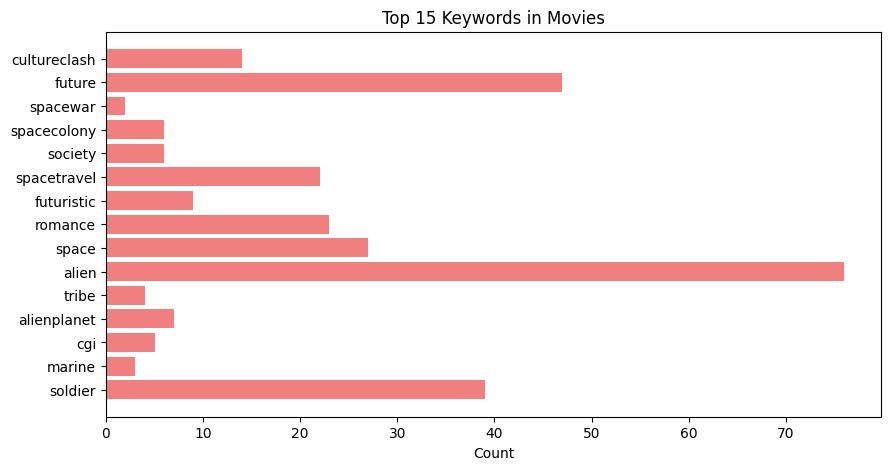

In [15]:
from collections import Counter

all_keywords = [k for sublist in movies['keywords'] for k in sublist]
keyword_counts = Counter(all_keywords)

plt.figure(figsize=(10,5))
plt.barh(list(keyword_counts.keys())[:15], list(keyword_counts.values())[:15], color='lightcoral')
plt.title("Top 15 Keywords in Movies")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()


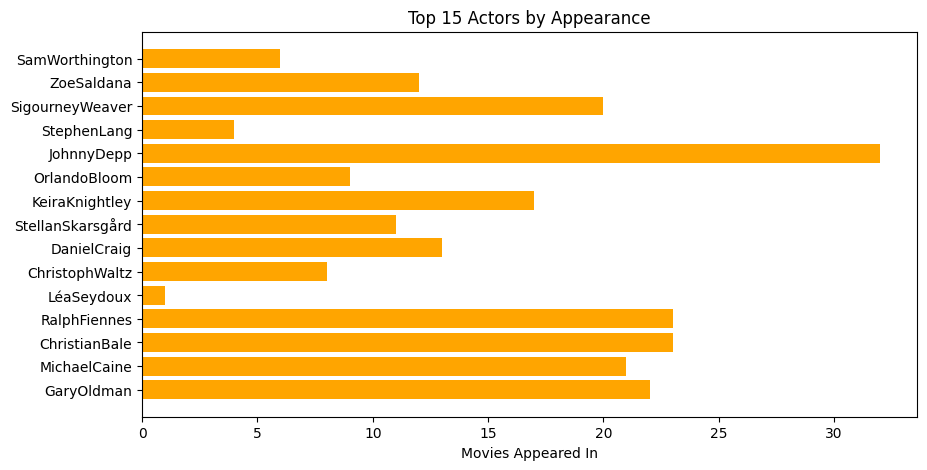

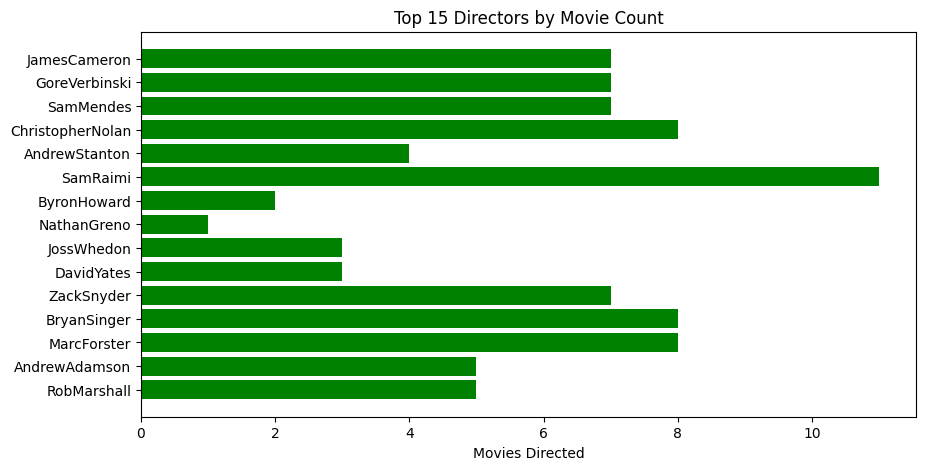

In [16]:
# Actors
all_actors = [a for sublist in movies['cast'] for a in sublist]
actor_counts = Counter(all_actors)
plt.figure(figsize=(10,5))
plt.barh(list(actor_counts.keys())[:15], list(actor_counts.values())[:15], color='orange')
plt.title("Top 15 Actors by Appearance")
plt.xlabel("Movies Appeared In")
plt.gca().invert_yaxis()
plt.show()

# Directors
all_directors = [d for sublist in movies['crew'] for d in sublist]
director_counts = Counter(all_directors)
plt.figure(figsize=(10,5))
plt.barh(list(director_counts.keys())[:15], list(director_counts.values())[:15], color='green')
plt.title("Top 15 Directors by Movie Count")
plt.xlabel("Movies Directed")
plt.gca().invert_yaxis()
plt.show()


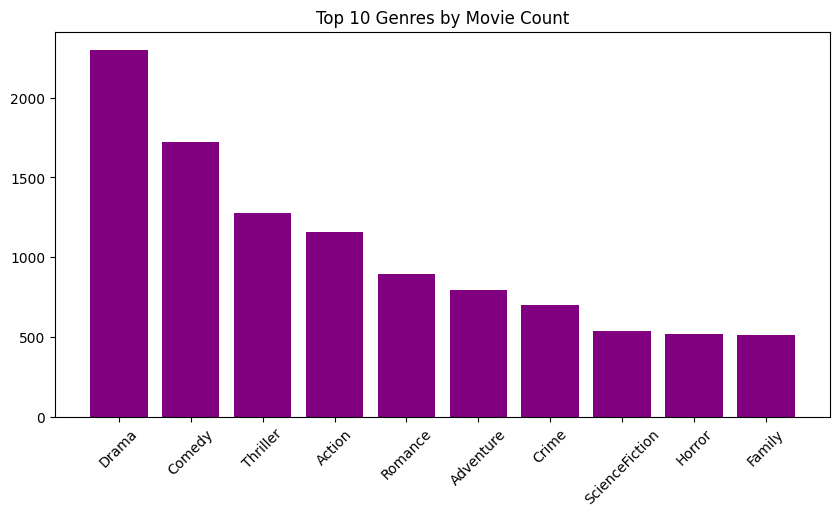

,Genre,Count
0,Drama,2299
1,Comedy,1723
2,Thriller,1275
3,Action,1156
4,Romance,895


In [17]:
import pandas as pd

# Expand genre lists into multiple rows
genre_df = movies[['movie_id', 'title', 'genres']].explode('genres')
genre_summary = genre_df['genres'].value_counts().reset_index()
genre_summary.columns = ['Genre', 'Count']

plt.figure(figsize=(10,5))
plt.bar(genre_summary['Genre'][:10], genre_summary['Count'][:10], color='purple')
plt.title("Top 10 Genres by Movie Count")
plt.xticks(rotation=45)
plt.show()

genre_summary.head()


In [18]:
import sqlite3

conn = sqlite3.connect(":memory:")
movies_exploded = movies[['movie_id','title']].join(genre_df['genres'])
movies_exploded.to_sql('movies', conn, index=False, if_exists='replace')

query = """
SELECT genres AS Genre, COUNT(*) AS Count
FROM movies
GROUP BY Genre
ORDER BY Count DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)


,Genre,Count
0,Drama,2299
1,Comedy,1723
2,Thriller,1275
3,Action,1156
4,Romance,895
5,Adventure,792
6,Crime,697
7,ScienceFiction,538
8,Horror,520
9,Family,514


RECOMMENDER SYSTEM

In [12]:
!pip install nltk

In [13]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def stem(txt):
  L = []
  for i in txt.split(): # Split the text into words before stemming
    L.append(ps.stem(i))
  return " ".join(L)

new_df['tags'] = new_df['tags'].apply(stem)

/tmp/ipython-input-3844100602.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english',max_features = 5000)
vectors = cv.fit_transform(new_df['tags']).toarray()
vectors[0]

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
!pip install nltk
import nltk
nltk.download('punkt') # Download necessary NLTK data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
cv.get_feature_names_out()

array(['000', '007', '10', ..., 'zone', 'zoo', 'zooeydeschanel'],
      dtype=object)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)
print(similarity.shape)

(4806, 4806)


In [23]:
new_df

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...
3,49026,The Dark Knight Rises,follow the death of district attorney harvey d...
4,49529,John Carter,"john carter is a war-weary, former militari ca..."
...,...,...,...
4804,9367,El Mariachi,el mariachi just want to play hi guitar and ca...
4805,72766,Newlyweds,a newlyw couple' honeymoon is upend by the arr...
4806,231617,"Signed, Sealed, Delivered","""signed, sealed, delivered"" introduc a dedic q..."
4807,126186,Shanghai Calling,when ambiti new york attorney sam is sent to s...


In [24]:
# list(enumerate(distances)) -> return tuple of index,value
def recommend(movie):
  movie_idx = new_df[new_df['title'] == movie].index[0]
  distances = similarity[movie_idx]
  movies_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
  for i in movies_list:
    print(new_df.iloc[i[0]].title)
recommend('Batman Begins')

import pickle
with open('movies_dict.pkl','wb') as f:
  pickle.dump(new_df,f)

with open('similarity.pkl','wb') as f:
  pickle.dump(similarity,f)


The Dark Knight
Batman
Batman
The Dark Knight Rises
10th & Wolf


In [25]:
similarity

array([[1.        , 0.0833655 , 0.08718573, ..., 0.04604093, 0.        ,
        0.        ],
       [0.0833655 , 1.        , 0.05976143, ..., 0.02366905, 0.        ,
        0.02577696],
       [0.08718573, 0.05976143, 1.        , ..., 0.02475369, 0.        ,
        0.        ],
       ...,
       [0.04604093, 0.02366905, 0.02475369, ..., 1.        , 0.040008  ,
        0.04270814],
       [0.        , 0.        , 0.        , ..., 0.040008  , 1.        ,
        0.08714204],
       [0.        , 0.02577696, 0.        , ..., 0.04270814, 0.08714204,
        1.        ]])